# ChIP AML PiPeline v2

In [137]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats
import numpy as np

from JKBio.epigenetics import chipseq as chip
from JKBio.utils import helper
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv
from collections import Counter

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [11]:
%store -r merged
%store -r chrombed
%store -r mergedpeak
%store -r cols
%store -r annot
%store -r version
%store -r merging_version
%store -r window

## Doing Motif analysis

In [181]:
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta ../../data/ref
! gsutil cp gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict ../../data/ref

Copying gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.dict...
/ [1 files][568.1 KiB/568.1 KiB]                                                
Operation completed over 1 objects/568.1 KiB.                                    


In [170]:
gatk='java -jar ~/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar'

In [172]:
#snps
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz ../temp/input_snp.vcf.gz

Copying gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/f6f6b60e-cce8-45ef-aa4f-ef2a9c636ebe/Cram2FilteredVcf/4297eb57-caaa-4c7f-8d36-446174db724f/call-FilterVariantTranches/CDS-XBgVc6_cnn_filtered.vcf.gz...
- [1 files][250.3 MiB/250.3 MiB]                                                
Operation completed over 1 objects/250.3 MiB.                                    


In [174]:
#sv
! gsutil cp gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/9ae3fbbd-10d4-41ad-9fb1-b2c845bc8b1b/MantaGermlineSV/955dcfd1-a991-4ed0-b86f-d05af81b1bf9/call-Manta/CDS-XBgVc6.diploidSV.vcf.gz ../temp/input_sv.vcf.gz

Copying gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/9ae3fbbd-10d4-41ad-9fb1-b2c845bc8b1b/MantaGermlineSV/955dcfd1-a991-4ed0-b86f-d05af81b1bf9/call-Manta/CDS-XBgVc6.diploidSV.vcf.gz...
/ [1 files][694.2 KiB/694.2 KiB]                                                
Operation completed over 1 objects/694.2 KiB.                                    


In [176]:
! $gatk MergeVcfs INPUT=../temp/input_snp.vcf.gz INPUT=../temp/input_sv.vcf.gz OUTPUT=../temp/input.vcf

INFO	2021-01-14 15:16:33	MergeVcfs	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MergeVcfs -INPUT ../temp/input_snp.vcf.gz -INPUT ../temp/input_sv.vcf.gz -OUTPUT ../temp/input.vcf
**********


15:16:33.308 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jeremie/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
[Thu Jan 14 15:16:33 UTC 2021] MergeVcfs INPUT=[../temp/input_snp.vcf.gz, ../temp/input_sv.vcf.gz] OUTPUT=../temp/input.vcf    VERBOSITY=INFO QUIET=false VALIDATION_STRINGENCY=STRICT COMPRESSION_LEVEL=2 MAX_RECORDS_IN_RAM=500000 CREATE_INDEX=true CREATE_MD5_FILE=false GA4GH_CLIENT_SECRETS=client_secrets.json USE_JDK_DEFLATER=false US

INFO	2021-01-14 15:16:40	MergeVcfs	Processed       410,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:32,723,556
INFO	2021-01-14 15:16:40	MergeVcfs	Processed       420,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:37,846,465
INFO	2021-01-14 15:16:41	MergeVcfs	Processed       430,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:43,986,903
INFO	2021-01-14 15:16:41	MergeVcfs	Processed       440,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:50,213,038
INFO	2021-01-14 15:16:41	MergeVcfs	Processed       450,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:55,743,695
INFO	2021-01-14 15:16:41	MergeVcfs	Processed       460,000 records.  Elapsed time: 00:00:07s.  Time for last 10,000:    0s.  Last read position: chr2:62,381,459
INFO	2021-01-14 15:16:41	MergeVcfs

INFO	2021-01-14 15:16:47	MergeVcfs	Processed       920,000 records.  Elapsed time: 00:00:13s.  Time for last 10,000:    0s.  Last read position: chr3:119,280,503
INFO	2021-01-14 15:16:47	MergeVcfs	Processed       930,000 records.  Elapsed time: 00:00:13s.  Time for last 10,000:    0s.  Last read position: chr3:126,127,218
INFO	2021-01-14 15:16:47	MergeVcfs	Processed       940,000 records.  Elapsed time: 00:00:14s.  Time for last 10,000:    0s.  Last read position: chr3:132,517,817
INFO	2021-01-14 15:16:47	MergeVcfs	Processed       950,000 records.  Elapsed time: 00:00:14s.  Time for last 10,000:    0s.  Last read position: chr3:138,877,208
INFO	2021-01-14 15:16:47	MergeVcfs	Processed       960,000 records.  Elapsed time: 00:00:14s.  Time for last 10,000:    0s.  Last read position: chr3:145,539,637
INFO	2021-01-14 15:16:47	MergeVcfs	Processed       970,000 records.  Elapsed time: 00:00:14s.  Time for last 10,000:    0s.  Last read position: chr3:152,404,963
INFO	2021-01-14 15:16:48	Mer

INFO	2021-01-14 15:16:53	MergeVcfs	Processed     1,430,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:35,804,059
INFO	2021-01-14 15:16:53	MergeVcfs	Processed     1,440,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:42,474,627
INFO	2021-01-14 15:16:53	MergeVcfs	Processed     1,450,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:50,033,928
INFO	2021-01-14 15:16:54	MergeVcfs	Processed     1,460,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:55,642,872
INFO	2021-01-14 15:16:54	MergeVcfs	Processed     1,470,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:62,314,428
INFO	2021-01-14 15:16:54	MergeVcfs	Processed     1,480,000 records.  Elapsed time: 00:00:20s.  Time for last 10,000:    0s.  Last read position: chr5:71,823,983
INFO	2021-01-14 15:16:54	MergeVcfs

INFO	2021-01-14 15:16:59	MergeVcfs	Processed     1,940,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:21,655,066
INFO	2021-01-14 15:16:59	MergeVcfs	Processed     1,950,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:27,403,572
INFO	2021-01-14 15:17:00	MergeVcfs	Processed     1,960,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:33,663,330
INFO	2021-01-14 15:17:00	MergeVcfs	Processed     1,970,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:39,586,176
INFO	2021-01-14 15:17:00	MergeVcfs	Processed     1,980,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:46,283,796
INFO	2021-01-14 15:17:00	MergeVcfs	Processed     1,990,000 records.  Elapsed time: 00:00:26s.  Time for last 10,000:    0s.  Last read position: chr7:51,889,323
INFO	2021-01-14 15:17:00	MergeVcfs

INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,450,000 records.  Elapsed time: 00:00:32s.  Time for last 10,000:    0s.  Last read position: chr9:33,851,167
INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,460,000 records.  Elapsed time: 00:00:32s.  Time for last 10,000:    0s.  Last read position: chr9:40,873,642
INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,470,000 records.  Elapsed time: 00:00:32s.  Time for last 10,000:    0s.  Last read position: chr9:61,723,178
INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,480,000 records.  Elapsed time: 00:00:32s.  Time for last 10,000:    0s.  Last read position: chr9:68,401,642
INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,490,000 records.  Elapsed time: 00:00:33s.  Time for last 10,000:    0s.  Last read position: chr9:74,704,842
INFO	2021-01-14 15:17:06	MergeVcfs	Processed     2,500,000 records.  Elapsed time: 00:00:33s.  Time for last 10,000:    0s.  Last read position: chr9:81,397,614
INFO	2021-01-14 15:17:06	MergeVcfs

INFO	2021-01-14 15:17:14	MergeVcfs	Processed     2,960,000 records.  Elapsed time: 00:00:40s.  Time for last 10,000:    0s.  Last read position: chr11:84,709,060
INFO	2021-01-14 15:17:14	MergeVcfs	Processed     2,970,000 records.  Elapsed time: 00:00:40s.  Time for last 10,000:    0s.  Last read position: chr11:90,642,392
INFO	2021-01-14 15:17:14	MergeVcfs	Processed     2,980,000 records.  Elapsed time: 00:00:41s.  Time for last 10,000:    0s.  Last read position: chr11:96,368,847
INFO	2021-01-14 15:17:14	MergeVcfs	Processed     2,990,000 records.  Elapsed time: 00:00:41s.  Time for last 10,000:    0s.  Last read position: chr11:101,337,547
INFO	2021-01-14 15:17:14	MergeVcfs	Processed     3,000,000 records.  Elapsed time: 00:00:41s.  Time for last 10,000:    0s.  Last read position: chr11:107,227,626
INFO	2021-01-14 15:17:15	MergeVcfs	Processed     3,010,000 records.  Elapsed time: 00:00:41s.  Time for last 10,000:    0s.  Last read position: chr11:114,264,065
INFO	2021-01-14 15:17:15	

INFO	2021-01-14 15:17:20	MergeVcfs	Processed     3,470,000 records.  Elapsed time: 00:00:46s.  Time for last 10,000:    0s.  Last read position: chr14:65,851,967
INFO	2021-01-14 15:17:20	MergeVcfs	Processed     3,480,000 records.  Elapsed time: 00:00:47s.  Time for last 10,000:    0s.  Last read position: chr14:73,730,278
INFO	2021-01-14 15:17:20	MergeVcfs	Processed     3,490,000 records.  Elapsed time: 00:00:47s.  Time for last 10,000:    0s.  Last read position: chr14:80,105,570
INFO	2021-01-14 15:17:20	MergeVcfs	Processed     3,500,000 records.  Elapsed time: 00:00:47s.  Time for last 10,000:    0s.  Last read position: chr14:86,908,901
INFO	2021-01-14 15:17:20	MergeVcfs	Processed     3,510,000 records.  Elapsed time: 00:00:47s.  Time for last 10,000:    0s.  Last read position: chr14:94,939,714
INFO	2021-01-14 15:17:21	MergeVcfs	Processed     3,520,000 records.  Elapsed time: 00:00:47s.  Time for last 10,000:    0s.  Last read position: chr14:100,653,136
INFO	2021-01-14 15:17:21	Me

INFO	2021-01-14 15:17:26	MergeVcfs	Processed     3,980,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:47,713,208
INFO	2021-01-14 15:17:26	MergeVcfs	Processed     3,990,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:53,653,548
INFO	2021-01-14 15:17:26	MergeVcfs	Processed     4,000,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:59,514,613
INFO	2021-01-14 15:17:27	MergeVcfs	Processed     4,010,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:65,864,748
INFO	2021-01-14 15:17:27	MergeVcfs	Processed     4,020,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:70,757,872
INFO	2021-01-14 15:17:27	MergeVcfs	Processed     4,030,000 records.  Elapsed time: 00:00:53s.  Time for last 10,000:    0s.  Last read position: chr18:75,797,792
INFO	2021-01-14 15:17:27	Mer

INFO	2021-01-14 15:17:32	MergeVcfs	Processed     4,490,000 records.  Elapsed time: 00:00:59s.  Time for last 10,000:    0s.  Last read position: chrX:121,011,254
INFO	2021-01-14 15:17:33	MergeVcfs	Processed     4,500,000 records.  Elapsed time: 00:00:59s.  Time for last 10,000:    0s.  Last read position: chrX:137,462,709
INFO	2021-01-14 15:17:33	MergeVcfs	Processed     4,510,000 records.  Elapsed time: 00:00:59s.  Time for last 10,000:    0s.  Last read position: chrX:148,650,176
INFO	2021-01-14 15:17:33	MergeVcfs	Processed     4,520,000 records.  Elapsed time: 00:00:59s.  Time for last 10,000:    0s.  Last read position: chrY:11,332,163
[Thu Jan 14 15:17:33 UTC 2021] picard.vcf.MergeVcfs done. Elapsed time: 1.00 minutes.
Runtime.totalMemory()=2332033024
Tool returned:
0


In [183]:
! cp ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed

In [185]:
! $gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O ../temp/middle.fasta -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.bed -V ../temp/input.vcf && fold ../temp/middle.fasta -w 500 > ../../data/$project/MEME_$version/ATAC.fasta

15:30:26.341 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/jeremie/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
Jan 14, 2021 3:30:26 PM shaded.cloud_nio.com.google.auth.oauth2.DefaultCredentialsProvider warnAboutProblematicCredentials
15:30:26.557 INFO  FastaAlternateReferenceMaker - ------------------------------------------------------------
15:30:26.558 INFO  FastaAlternateReferenceMaker - The Genome Analysis Toolkit (GATK) v4.1.9.0
15:30:26.558 INFO  FastaAlternateReferenceMaker - For support and documentation go to https://software.broadinstitute.org/gatk/
15:30:26.558 INFO  FastaAlternateReferenceMaker - Executing as jeremie@runningchip2.c.aml-chipseq-rnaseq-259419.internal on Linux v4.9.0-11-amd64 amd64
15:30:26.558 INFO  FastaAlternateReferenceMaker - Java runtime: OpenJDK 64-Bit Server VM v11.0.6+10-post-Debian-1
15:30:26.558 INFO  FastaAlternateReferenceMaker - Start Date/Time: January 14, 2021 at 3:30

15:38:09.703 INFO  ProgressMeter -       chr18:59265724              7.7              72575000        9439238.4
15:38:19.709 INFO  ProgressMeter -        chr20:4665995              7.9              77000000        9802153.5
15:38:29.725 INFO  ProgressMeter -       chr20:34205794              8.0              77836000        9702414.1
15:38:39.728 INFO  ProgressMeter -       chr21:42534894              8.2              79929000        9760453.0
15:38:41.332 INFO  FastaAlternateReferenceMaker - Shutting down engine
[January 14, 2021 at 3:38:41 PM UTC] org.broadinstitute.hellbender.tools.walkers.fasta.FastaAlternateReferenceMaker done. Elapsed time: 8.25 minutes.
Runtime.totalMemory()=2483027968
java.lang.IllegalStateException: no base was added
	at htsjdk.samtools.reference.FastaReferenceWriter.closeSequence(FastaReferenceWriter.java:431)
	at htsjdk.samtools.reference.FastaReferenceWriter.startSequence(FastaReferenceWriter.java:406)
	at htsjdk.samtools.reference.FastaReferenceWriter.appe

In [27]:
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast
! mkdir ../../data/$project/MEME_$version/
! gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O - -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak -V input.vcf | fold -w 500 > ../../data/$project/MEME_$version/ATAC.fasta

cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && fimo --oc ../../data/"+project+"/MEME_"+version+"/ATAC/ ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme ../../data/"+project+"/MEME_"+version+"/ATAC.fasta"
! $cmd

! gff2bed < ../../data/$project/MEME_$version/ATAC/fimo.gff > ../../data/$project/MEME_$version/ATAC/fimo.gff.bed

mkdir: cannot create directory ‘../../data/Cobinding_ChIP/MEME_v3/ATAC/’: File exists
Using motif +AHR_HUMAN.H11MO.0.B of width 9.
Using motif -AHR_HUMAN.H11MO.0.B of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.9225
Using motif +AIRE_HUMAN.H11MO.0.C of width 18.
Using motif -AIRE_HUMAN.H11MO.0.C of width 18.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ALX1_HUMAN.H11MO.0.B of width 12.
Using motif -ALX1_HUMAN.H11MO.0.B of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ALX3_HUMAN.H11MO.0.D of width 11.
Using motif -ALX3_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ALX4_HUMAN.H11MO.0.D of widt

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999598
Using motif +BATF_HUMAN.H11MO.1.A of width 11.
Using motif -BATF_HUMAN.H11MO.1.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.996308
Using motif +BC11A_HUMAN.H11MO.0.A of width 17.
Using motif -BC11A_HUMAN.H11MO.0.A of width 17.
Motif matches with p-value >= 3.5e-05 have been dropped to reclaim memory.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.963978
Using motif +BCL6B_HUMAN.H11MO.0.D of width 11.
Using motif -BCL6B_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +BCL6_HUMAN.H11MO.0.A of width 13.
Using motif -BCL6_HUMAN.H11MO.0.A of width 13.
Computing q-values.
  Estima

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999596
Using motif +CRX_HUMAN.H11MO.0.B of width 13.
Using motif -CRX_HUMAN.H11MO.0.B of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +CUX2_HUMAN.H11MO.0.D of width 11.
Using motif -CUX2_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +CXXC1_HUMAN.H11MO.0.D of width 7.
Using motif -CXXC1_HUMAN.H11MO.0.D of width 7.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.992609
Using motif +DBP_HUMAN.H11MO.0.B of width 11.
Using motif -DBP_HUMAN.H11MO.0.B of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated p

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.909624
Using motif +EHF_HUMAN.H11MO.0.B of width 15.
Using motif -EHF_HUMAN.H11MO.0.B of width 15.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.953957
Using motif +ELF1_HUMAN.H11MO.0.A of width 14.
Using motif -ELF1_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.982222
Using motif +ELF2_HUMAN.H11MO.0.C of width 13.
Using motif -ELF2_HUMAN.H11MO.0.C of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.946423
Using motif +ELF3_HUMAN.H11MO.0.A of width 14.
Using motif -ELF3_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_

Motif matches with p-value >= 3.5e-05 have been dropped to reclaim memory.
Motif matches with p-value >= 1.2e-05 have been dropped to reclaim memory.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.911391
Using motif +FLI1_HUMAN.H11MO.1.A of width 13.
Using motif -FLI1_HUMAN.H11MO.1.A of width 13.
Motif matches with p-value >= 3.3e-05 have been dropped to reclaim memory.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.960468
Using motif +FOSB_HUMAN.H11MO.0.A of width 9.
Using motif -FOSB_HUMAN.H11MO.0.A of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999196
Using motif +FOSL1_HUMAN.H11MO.0.A of width 12.
Using motif -FOSL1_HUMAN.H11MO.0.A of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating p

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.967314
Using motif +GATA1_HUMAN.H11MO.0.A of width 19.
Using motif -GATA1_HUMAN.H11MO.0.A of width 19.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999899
Using motif +GATA1_HUMAN.H11MO.1.A of width 11.
Using motif -GATA1_HUMAN.H11MO.1.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +GATA2_HUMAN.H11MO.0.A of width 19.
Using motif -GATA2_HUMAN.H11MO.0.A of width 19.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999296
Using motif +GATA2_HUMAN.H11MO.1.A of width 11.
Using motif -GATA2_HUMAN.H11MO.1.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating 

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.984114
Using motif +HEY1_HUMAN.H11MO.0.D of width 12.
Using motif -HEY1_HUMAN.H11MO.0.D of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.927706
Using motif +HEY2_HUMAN.H11MO.0.D of width 17.
Using motif -HEY2_HUMAN.H11MO.0.D of width 17.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.877414
Using motif +HIC1_HUMAN.H11MO.0.C of width 9.
Using motif -HIC1_HUMAN.H11MO.0.C of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.984094
Using motif +HIC2_HUMAN.H11MO.0.D of width 11.
Using motif -HIC2_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +HXB13_HUMAN.H11MO.0.A of width 10.
Using motif -HXB13_HUMAN.H11MO.0.A of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +HXB1_HUMAN.H11MO.0.D of width 10.
Using motif -HXB1_HUMAN.H11MO.0.D of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.998788
Using motif +HXB2_HUMAN.H11MO.0.D of width 15.
Using motif -HXB2_HUMAN.H11MO.0.D of width 15.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +HXB3_HUMAN.H11MO.0.D of width 14.
Using motif -HXB3_HUMAN.H11MO.0.D of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ISX_HUMAN.H11MO.0.D of width 16.
Using motif -ISX_HUMAN.H11MO.0.D of width 16.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ITF2_HUMAN.H11MO.0.C of width 10.
Using motif -ITF2_HUMAN.H11MO.0.C of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.96186
Using motif +JDP2_HUMAN.H11MO.0.D of width 12.
Using motif -JDP2_HUMAN.H11MO.0.D of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +JUNB_HUMAN.H11MO.0.A of width 11.
Using motif -JUNB_HUMAN.H11MO.0.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1


Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +LMX1B_HUMAN.H11MO.0.D of width 18.
Using motif -LMX1B_HUMAN.H11MO.0.D of width 18.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +LYL1_HUMAN.H11MO.0.A of width 14.
Using motif -LYL1_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.958315
Using motif +MAFA_HUMAN.H11MO.0.D of width 21.
Using motif -MAFA_HUMAN.H11MO.0.D of width 21.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.961136
Using motif +MAFB_HUMAN.H11MO.0.B of width 11.
Using motif -MAFB_HUMAN.H11MO.0.B of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estim

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +MSX1_HUMAN.H11MO.0.D of width 18.
Using motif -MSX1_HUMAN.H11MO.0.D of width 18.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999899
Using motif +MSX2_HUMAN.H11MO.0.D of width 7.
Using motif -MSX2_HUMAN.H11MO.0.D of width 7.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +MTF1_HUMAN.H11MO.0.C of width 17.
Using motif -MTF1_HUMAN.H11MO.0.C of width 17.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.951655
Using motif +MXI1_HUMAN.H11MO.0.A of width 15.
Using motif -MXI1_HUMAN.H11MO.0.A of width 15.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.978667
Using motif +NFYA_HUMAN.H11MO.0.A of width 14.
Using motif -NFYA_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +NFYB_HUMAN.H11MO.0.A of width 13.
Using motif -NFYB_HUMAN.H11MO.0.A of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.969079
Using motif +NFYC_HUMAN.H11MO.0.A of width 14.
Using motif -NFYC_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.95082
Using motif +NGN2_HUMAN.H11MO.0.D of width 12.
Using motif -NGN2_HUMAN.H11MO.0.D of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  E

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.96
Using motif +NR6A1_HUMAN.H11MO.0.B of width 13.
Using motif -NR6A1_HUMAN.H11MO.0.B of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.998995
Using motif +NRF1_HUMAN.H11MO.0.A of width 17.
Using motif -NRF1_HUMAN.H11MO.0.A of width 17.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.910656
Using motif +NRL_HUMAN.H11MO.0.D of width 11.
Using motif -NRL_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999698
Using motif +OLIG1_HUMAN.H11MO.0.D of width 14.
Using motif -OLIG1_HUMAN.H11MO.0.D of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +PBX2_HUMAN.H11MO.0.C of width 15.
Using motif -PBX2_HUMAN.H11MO.0.C of width 15.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +PBX3_HUMAN.H11MO.0.A of width 11.
Using motif -PBX3_HUMAN.H11MO.0.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.942481
Using motif +PBX3_HUMAN.H11MO.1.A of width 9.
Using motif -PBX3_HUMAN.H11MO.1.A of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.976571
Using motif +PDX1_HUMAN.H11MO.0.A of width 9.
Using motif -PDX1_HUMAN.H11MO.0.A of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated p

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.999495
Using motif +PRDM6_HUMAN.H11MO.0.C of width 13.
Using motif -PRDM6_HUMAN.H11MO.0.C of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.995477
Using motif +PRGR_HUMAN.H11MO.0.A of width 16.
Using motif -PRGR_HUMAN.H11MO.0.A of width 16.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.99809
Using motif +PRGR_HUMAN.H11MO.1.A of width 9.
Using motif -PRGR_HUMAN.H11MO.1.A of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.965287
Using motif +PROP1_HUMAN.H11MO.0.D of width 11.
Using motif -PROP1_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating 

  Estimated pi_0=0.974881
Using motif +RUNX2_HUMAN.H11MO.0.A of width 14.
Using motif -RUNX2_HUMAN.H11MO.0.A of width 14.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.965
Using motif +RUNX3_HUMAN.H11MO.0.A of width 10.
Using motif -RUNX3_HUMAN.H11MO.0.A of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.970964
Using motif +RXRA_HUMAN.H11MO.0.A of width 20.
Using motif -RXRA_HUMAN.H11MO.0.A of width 20.
Motif matches with p-value >= 4e-05 have been dropped to reclaim memory.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.920248
Using motif +RXRA_HUMAN.H11MO.1.A of width 10.
Using motif -RXRA_HUMAN.H11MO.1.A of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.950909


  Estimated pi_0=0.957625
Using motif +SOX5_HUMAN.H11MO.0.C of width 8.
Using motif -SOX5_HUMAN.H11MO.0.C of width 8.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +SOX7_HUMAN.H11MO.0.D of width 16.
Using motif -SOX7_HUMAN.H11MO.0.D of width 16.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +SOX8_HUMAN.H11MO.0.D of width 16.
Using motif -SOX8_HUMAN.H11MO.0.D of width 16.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.998894
Using motif +SOX9_HUMAN.H11MO.0.B of width 16.
Using motif -SOX9_HUMAN.H11MO.0.B of width 16.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.996447
Using motif +SOX9_HUMAN.H11MO.1.B of width 9.
Using motif -SOX9_HUMAN.H11MO.1.B of width 9

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.981915
Using motif +STAT3_HUMAN.H11MO.0.A of width 12.
Using motif -STAT3_HUMAN.H11MO.0.A of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.995979
Using motif +STAT4_HUMAN.H11MO.0.A of width 11.
Using motif -STAT4_HUMAN.H11MO.0.A of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.992565
Using motif +STAT6_HUMAN.H11MO.0.B of width 11.
Using motif -STAT6_HUMAN.H11MO.0.B of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.993061
Using motif +STF1_HUMAN.H11MO.0.B of width 11.
Using motif -STF1_HUMAN.H11MO.0.B of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estima

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.949548
Using motif +TFE3_HUMAN.H11MO.0.B of width 10.
Using motif -TFE3_HUMAN.H11MO.0.B of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.954495
Using motif +TFEB_HUMAN.H11MO.0.C of width 9.
Using motif -TFEB_HUMAN.H11MO.0.C of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +TGIF1_HUMAN.H11MO.0.A of width 7.
Using motif -TGIF1_HUMAN.H11MO.0.A of width 7.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.954625
Using motif +TGIF2_HUMAN.H11MO.0.D of width 11.
Using motif -TGIF2_HUMAN.H11MO.0.D of width 11.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.924552
Using motif +Z354A_HUMAN.H11MO.0.C of width 24.
Using motif -Z354A_HUMAN.H11MO.0.C of width 24.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.991122
Using motif +ZBED1_HUMAN.H11MO.0.D of width 13.
Using motif -ZBED1_HUMAN.H11MO.0.D of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.979455
Using motif +ZBT14_HUMAN.H11MO.0.C of width 9.
Using motif -ZBT14_HUMAN.H11MO.0.C of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.97575
Using motif +ZBT17_HUMAN.H11MO.0.A of width 19.
Using motif -ZBT17_HUMAN.H11MO.0.A of width 19.
Motif matches with p-value >= 3e-05 have been dropped to reclaim memory.
Motif matches with p-v

  Estimated pi_0=0.999899
Using motif +ZN140_HUMAN.H11MO.0.C of width 24.
Using motif -ZN140_HUMAN.H11MO.0.C of width 24.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.986196
Using motif +ZN143_HUMAN.H11MO.0.A of width 22.
Using motif -ZN143_HUMAN.H11MO.0.A of width 22.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.967758
Using motif +ZN148_HUMAN.H11MO.0.D of width 15.
Using motif -ZN148_HUMAN.H11MO.0.D of width 15.
Motif matches with p-value >= 3.2e-05 have been dropped to reclaim memory.
Motif matches with p-value >= 9.2e-06 have been dropped to reclaim memory.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.922105
Using motif +ZN214_HUMAN.H11MO.0.C of width 22.
Using motif -ZN214_HUMAN.H11MO.0.C of width 22.
Computing q-values.
  Estimating pi_0 from a un

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.957952
Using motif +ZN410_HUMAN.H11MO.0.D of width 13.
Using motif -ZN410_HUMAN.H11MO.0.D of width 13.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +ZN418_HUMAN.H11MO.0.C of width 17.
Using motif -ZN418_HUMAN.H11MO.0.C of width 17.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.970879
Using motif +ZN418_HUMAN.H11MO.1.D of width 12.
Using motif -ZN418_HUMAN.H11MO.1.D of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.980541
Using motif +ZN423_HUMAN.H11MO.0.D of width 15.
Using motif -ZN423_HUMAN.H11MO.0.D of width 15.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating 

Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.941183
Using motif +ZNF18_HUMAN.H11MO.0.C of width 12.
Using motif -ZNF18_HUMAN.H11MO.0.C of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.962824
Using motif +ZNF41_HUMAN.H11MO.0.C of width 24.
Using motif -ZNF41_HUMAN.H11MO.0.C of width 24.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.961582
Using motif +ZNF41_HUMAN.H11MO.1.C of width 12.
Using motif -ZNF41_HUMAN.H11MO.1.C of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.979027
Using motif +ZNF76_HUMAN.H11MO.0.C of width 22.
Using motif -ZNF76_HUMAN.H11MO.0.C of width 22.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Esti

In [9]:
merged_motif = pd.read_csv('../../data/MEME/merged/fimo.gff.bed', sep='\t',skiprows=0,index_col=None, names=['pos', 'relstart', 'relend', "name", "strength","strand",'fimo','nucleotide_motif',".","data"])

merged_motif['tf'] = [i.split('_HUMAN')[0] for i in merged_motif.name]
merged_motif.relstart = merged_motif.relstart.astype(int)
merged_motif.start = merged_motif.start.astype(int)
merged_motif.relend = merged_motif.relend.astype(int)
merged_motif.start = merged_motif.start+merged_motif.relstart
merged_motif.end = merged_motif.start+merged_motif.relend
merged_motif['chrom'] = [i.split(':')[0][3:] for i in merged_motif.pos]
merged_motif['start'] = [i.split(':')[1].split('-')[0] for i in merged_motif.pos]

In [35]:
rn={'HOXA9':'HXA9',
 'SREBF1':'SRBP1',
 'STAT5B':'STA5B',
 'ZEB2':"ZEB1",
 'ZNF281':'ZN281'}
proteins = []
for i in merged.columns[cols:]:
    for k,v in rn.items():
        i = i.replace(k,v)
    proteins.append(i)
set(proteins) - set(merged_motif.tf)

{'AFF4',
 'ATAC',
 'BRD4',
 'CDK13',
 'CDK9',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FOXP1_mot',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'LDB1',
 'LMO2',
 'MED1',
 'MLL_KTM2A',
 'MYBL2',
 'PLAGL2',
 'POLII',
 'PSER2',
 'SMC1',
 'WDR5',
 'ZMYND8',
 'activation',
 'promoters',
 'regular_enhancer',
 'repression',
 'super_enhancer'}

In [44]:
merged_motif = merged_motif[merged_motif.tf.isin(proteins)]
merged_motif['pval'] = [float(i.split('pvalue=')[1].split(';')[0]) for i in merged_motif.data]
merged_motif['seq'] = [i.split('sequence=')[1].split(';')[0] for i in merged_motif.data]
merged_motif = merged_motif[['chrom', 'start', 'end', "strength", 'pval','strand', 'tf','seq']].sort_values(by=['chrom','start','strength']).reset_index(drop = True)
merged_motif = merged_motif.rename(columns={'chr':'chrom'})
merged_motif.chrom = "chr"+merged_motif.chrom
merged_motif.chrom = merged_motif.chrom.astype(str)

In [56]:
a = {}
for k,v in rn.items():
    a[v] = k 
rn = a
merged_motif['tf'] = merged_motif['tf'].replace(rn)

In [47]:
merged_motif = merged_motif.rename(columns={'strength':"foldchange"})

In [49]:
merged_motif.to_csv('../results/'+project+'/'+version+'_merged_motif.bed', sep='\t')

## what motifs map to their right binding event

In [71]:
set(merged.columns)

{'-log10pvalue',
 '-log10qvalue',
 'AFF4',
 'ATAC',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPA_mot',
 'CEBPB',
 'CEBPB_mot',
 'CTCF',
 'CTCF_mot',
 'E2F3',
 'E2F3_mot',
 'ELF2',
 'ELF2_mot',
 'ETV6',
 'ETV6_mot',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FLI1_mot',
 'FOSL2',
 'FOSL2_mot',
 'FOXP1',
 'FOXP1_mot',
 'GATA2',
 'GATA2_mot',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'HOXA9_mot',
 'IKZF1',
 'IKZF1_mot',
 'IRF8',
 'IRF8_mot',
 'JUND',
 'JUND_mot',
 'LDB1',
 'LMO2',
 'LYL1',
 'LYL1_mot',
 'MAX',
 'MAX_mot',
 'MED1',
 'MEIS1',
 'MEIS1_mot',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYB_mot',
 'MYC',
 'MYC_mot',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RARA_mot',
 'RUNX1',
 'RUNX1_mot',
 'RUNX2',
 'RUNX2_mot',
 'RXRA',
 'RXRA_mot',
 'SMC1',
 'SP1',
 'SP1_mot',
 'SRBP1_mot',
 'SREBF1',
 'STAT5B',
 'STAT5B_mot',
 'TFAP4',
 'TFAP4_mot',
 'WDR5',
 'ZEB2',
 'ZEB2_mot',
 

In [48]:
for val in set(merged_motif.tf):
    merged[val+'_mot'] = chip.putInBed(merged[merged.columns[:cols]], merged_motif[merged_motif.tf==val], window=100)
merged = merged.replace(np.nan,0)

25208 were merged into conscensus
54903 were merged into conscensus
24089 were merged into conscensus
65091 were merged into conscensus
33666 were merged into conscensus
42825 were merged into conscensus
32539 were merged into conscensus
16402 were merged into conscensus
20276 were merged into conscensus
14741 were merged into conscensus
21896 were merged into conscensus
100287 were merged into conscensus
18913 were merged into conscensus
24846 were merged into conscensus
25447 were merged into conscensus
89784 were merged into conscensus
43004 were merged into conscensus
35733 were merged into conscensus
33211 were merged into conscensus
27676 were merged into conscensus
45552 were merged into conscensus
55072 were merged into conscensus
42383 were merged into conscensus
32933 were merged into conscensus
23000 were merged into conscensus
30475 were merged into conscensus
31295 were merged into conscensus
27557 were merged into conscensus
75131 were merged into conscensus


In [78]:
merged[merged["MAX_mot"]!=0]["STAT5B"].astype(bool).sum() / merged["MAX_mot"].astype(bool).sum()

0.3993817949264549

### computing perc overlap

In [114]:
a = []
b = []
for val in set(merged.columns[8:]):
    if '_mot' in val:
        b.append(val[:-4])
        a.append(merged[merged[val]!=0][val[:-4]].astype(bool).sum() / merged[val[:-4]].astype(bool).sum())

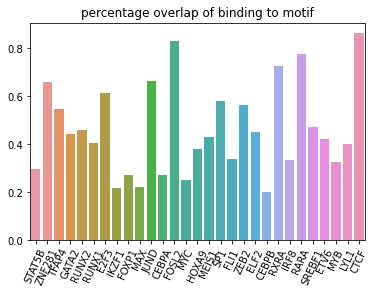

In [115]:
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T)
plt.xticks(rotation=65)
plt.title("percentage overlap of binding to motif")
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"percentage_overlap_binding2motif.pdf")

In [118]:
np.mean(a)

0.46220848463486913

In [98]:
mergedmot = merged
%store mergedmot

Stored 'mergedmot' (DataFrame)


## What are the motifs of our CRC members in ATACseq but not in our matrix


In [99]:
overlap = [25208, 54903, 24089, 65091, 33666, 42825, 32539, 16402, 20276, 14741, 21896, 100287, 18913, 24846, 25447, 89784, 43004, 35733, 33211, 27676, 45552, 55072, 42383, 32933, 23000, 30475, 31295, 27557, 75131]

Index(['FOXP1_mot', 'ZNF281_mot', 'MAX_mot', 'CTCF_mot', 'SREBF1_mot',
       'RUNX1_mot', 'ZEB2_mot', 'CEBPB_mot', 'IKZF1_mot', 'HOXA9_mot',
       'MYB_mot', 'RARA_mot', 'CEBPA_mot', 'STAT5B_mot', 'IRF8_mot',
       'RXRA_mot', 'MEIS1_mot', 'E2F3_mot', 'LYL1_mot', 'ELF2_mot', 'FLI1_mot',
       'RUNX2_mot', 'TFAP4_mot', 'ETV6_mot', 'MYC_mot', 'FOSL2_mot',
       'JUND_mot', 'GATA2_mot', 'SP1_mot'],
      dtype='object')

In [110]:
merged_motif['tf'] = merged_motif.tf.replace({"SRBP1":"SREBF1","HXA9":"HOXA9"})

In [111]:
a = []
b = []
for i, val in enumerate([i[:-4] for i in merged.columns[72:]]):
    b.append(val)
    a.append(overlap[i] / (merged_motif.tf==val).sum())

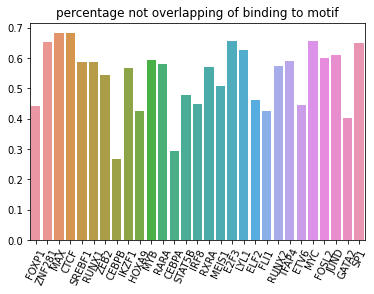

In [112]:
sns.barplot(data=pd.DataFrame(data = a, index=b, columns=['counts']).T)
plt.xticks(rotation=65)
plt.title("percentage not overlapping of binding to motif")
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"percentage_nonoverlap_binding2motif.pdf")

In [142]:
merged.columns[8:37]

Index(['CEBPA', 'HOXA9', 'PLAGL2', 'MEIS1', 'ETV6', 'HEX', 'FLAG_GFI1',
       'RUNX1', 'FOSL2', 'FLI1', 'GATA2', 'SP1', 'E2F3', 'ZNF281', 'SREBF1',
       'LMO2', 'STAT5B', 'ZMYND8', 'FLAG_MEF2C', 'LYL1', 'MYC', 'TFAP4',
       'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D'],
      dtype='object')

In [164]:
## what enrichment do we have in each group? what enrichment do we have for each ChipSeq?
for i, val in enumerate([i[:-4] for i in merged.columns[72:]]):
    a,b = np.where(merged[(merged[val]!=0)& (merged[val+'_mot']!=0)][merged.columns[8:37]]!=0) #72
    e = []
    u = []
    preva=a[0]
    print('_________________')
    print(val)
    for i, v in enumerate(a):
        n = merged.columns[8+b[i]]
        if n == val or n=="CEBPA":
            continue
        if v == preva:
            u.append(n)
        else:
            e.append(tuple(u))
            u = [n]
        preva = v
    e = Counter(e)
    a = list(e.values())
    a.sort()
    a = a[::-1]
    for k, v in e.items():
        if v in a[:10]:
            print(v,k)

_________________
FOXP1
108 ('RUNX2', 'IRF8')
75 ('MEIS1', 'RUNX2')
46 ('MEIS1', 'RUNX2', 'IRF8')
59 ('MEIS1',)
42 ('MEIS1', 'IRF8')
38 ('MEIS1', 'RUNX1', 'FLI1', 'MYC', 'RUNX2', 'MAX', 'IRF8')
64 ('IRF8',)
39 ('FLI1', 'RUNX2', 'IRF8')
36 ('RUNX1', 'RUNX2')
92 ('RUNX2',)
_________________
ZNF281
82 ('MAX',)
77 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
51 ('SP1',)
66 ('MYC', 'MAX')
72 ('IRF8',)
74 ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
51 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D')
77 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'M

31 ('PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'LYL1', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D')
30 ('PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D')
23 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
33 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
35 ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
28 ('PLAGL2', 'MEIS1', 'ETV6', 'RUNX1', 'FLI1', 'SP1', 'E2

188 ('MAX',)
380 ('IRF8',)
113 ('RUNX2', 'IRF8')
201 ('ETV6',)
197 ('RUNX2',)
90 ('MYC',)
80 ('MAX', 'IRF8')
132 ('MYC', 'MAX')
178 ('MEIS1',)
80 ('RUNX1',)
_________________
RUNX2
337 ('MAX',)
228 ('MYC', 'MAX')
264 ('MYC',)
891 ('RUNX1',)
234 ('RUNX1', 'MYC', 'MAX')
671 ('MEIS1',)
746 ('IRF8',)
223 ('FLAG_GFI1',)
324 ('FLI1',)
210 ('MEIS1', 'IRF8')
_________________
TFAP4
170 ('IRF8',)
146 ('MAX',)
69 ('FLI1',)
102 ('MEIS1',)
102 ('MYC', 'MAX')
60 ('RUNX1',)
115 ('RUNX2',)
52 ('MYC',)
47 ('MEIS1', 'MAX')
50 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'LMO2', 'STAT5B', 'ZMYND8', 'MYC', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'RXRA', 'FLAG_MEF2D')
_________________
ETV6
20 ('PLAGL2', 'MEIS1', 'FLAG_GFI1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2', 'STAT5B', 'ZMYND8', 'LYL1', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8', 'MYB', 'ZEB2', 'RXRA', 'FLAG_MEF2D')
18 ('PLAGL2', 'MEIS1', 'RUNX1', 'FLI1', 'SP1', 'E2F3', 'ZNF281', 'LMO2', 'STAT5B', 'ZMYND8', 'LYL1

In [165]:
ls input.vcf

ls: cannot access 'input.vcf': No such file or directory


In [ ]:
## computing predicted motif for each TF from Chip data MEME-Chip
## computing motif across the open region of the genome of MV411 from ATACseq with MEME.mast
#! mkdir ../../data/$project/MEME_$version/ATAC/
! gatk FastaAlternateReferenceMaker -R ../../data/ref/Homo_sapiens_assembly38.fasta -O - -L ../../data/$project/ATAC_MV411.mRp.clN_peaks.broadPeak -V input.vcf | fold -w 500 > ../../data/$project/MEME_$version/ATAC.fasta

cmd = "export PATH=$HOME/meme/bin:$HOME/meme/libexec/meme-5.1.1:$PATH && meme-chip [options] -db ../../motif_databases/HUMAN/HOCOMOCOv11_full_HUMAN_mono_meme_format.meme <primary sequence file>"

! $cmd

! gff2bed < ../../data/$project/MEME_$version/ATAC/fimo.gff > ../../data/$project/MEME_$version/ATAC/fimo.gff.bed

In [ ]:
## comparing with the litterature using MEME.tomtom


## Assigning genes

### based on closest expressed gene

In [ ]:
chiphelper.AssignToClosestExpressed()

In [ ]:
### recompute cobinding based on this.

In [ ]:
## redo the plots. do we get better plots?/correlations?...

### based on the ABC model

![](images/ABCtitle.png)

They tested a new model based on and validated by CRISPRi-FlowFISH which is basically able to find enhancer mapping to genes. 
They used it to compute their model's Accuracy and found a 70% accuracy compared to less than 50% for closest expressed gene. 

Way to integrate our HiC data (need ATAC-seq like data as well, but openly available) 


![](images/ABCmodel.png)

In [ ]:
Helper.scatter(TSNE(2,5).fit_transform(data.T), labels=zones.columns[11:],colors=labels)

In [ ]:
### recompute cobinding based on this.

In [ ]:
### redo the plots. do we get better looking plots?

In [ ]:
### compare presence of CTCF and transcription of linked RNA

## Predict

In [ ]:
## enrichment at the gene set level

In [ ]:
## are our cobinding clusters enriched in some sets of genes / CRC? 

In [ ]:
## make a linear model to with marks and cobinding data + motifs and TFs+cobinding motifs + expression of cobound proteins + expression , can we predict expression/dependenccy?

In [ ]:
## can we predict better for some set of genes / CRCs?

In [ ]:
## do the same on closest expressed gene

In [ ]:
## do this prediction on each enhancer.what is the best predicting enhancer? do that correlate with ABC model data?

In [ ]:
## do we get, for some gene, better single enhancer prediction?

In [ ]:
## what are the gene sets enriched in each clusters?? (based on TF cobinding or based on TF cobinding + )

## RNP data

In [ ]:
## can we predict RNP data (setting this TF to zero and lookingg at expected RNA change)
## do we see genes with opposite effects? 

In [ ]:
## if we add RNP data, can we increase our model's prediction? (we have expression change and we set all RNPed-TF values to 0) 

In [ ]:
### to predict remaining X% RNA expression
### to predict remaining X TFs RNP
### to predict regular RNA expression

In [ ]:
## same thing with filtering base on motif presence (actual DNA binding)
## same thing with closest expressed gene

In [ ]:
## Do on all cell lines

In [ ]:
## repeat the process across all samples with H3K27ac+RNAseq data we have.

In [ ]:
## call mutations from H3k27ac data

In [ ]:
## MEME analysis of likely bound TFs, except if TF is not expressed

In [ ]:
## compute enrichments

In [ ]:
## from same gene assignements, as found on the general consensus peak set, can we find good dependency/expression prediction

### Compare data with other labs (H3K27, HiC..)

we need to redo everything for similar normal cell type, getting TFs based on the CRC (find it with CRCmapper or on litterature)